In [1]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import cv2
from src import metrics




warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = './train/'
TEST_PATH = './test/'


In [156]:

tf.__version__

'2.1.0'

In [137]:
import tensorflow.compat.v1 as tf1 
#tf1.disable_v2_behavior()

In [3]:
from os import listdir
from os.path import isfile,join

In [4]:
filename = [f for f in listdir(TRAIN_PATH+'images/') if isfile(join(TRAIN_PATH+'images/',f))]

In [5]:
filename1 = [f for f in listdir(TRAIN_PATH+'masks/') if isfile(join(TRAIN_PATH+'masks/',f))]

In [6]:
len(filename1)

695

In [7]:
filenamet1 = [f for f in listdir(TEST_PATH+'masks/') if isfile(join(TEST_PATH+'masks/',f))]
filenamet = [f for f in listdir(TEST_PATH+'images/') if isfile(join(TEST_PATH+'images/',f))]

In [8]:
len(filename)

695

(256, 256, 1)


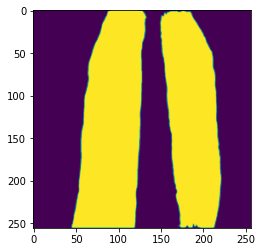

In [9]:
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
mask_ = imread(TRAIN_PATH + 'masks/' +filename1[0])
mask_ = rgb2gray(mask_)
mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                              preserve_range=True), axis=-1)
print(mask_.shape)
mask = np.maximum(mask, mask_)
plt.imshow(np.squeeze(mask))

In [10]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(filename), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(filename1), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 256 X 256
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in tqdm(enumerate(filename), total=len(filename)):
    path = TRAIN_PATH + 'images/'
    img = imread(path  +filename[n])
    if len(img.shape)<3:
        eq2 = cv2.equalizeHist(img)
        img = eq2
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        eq2 = cv2.equalizeHist(img)
        img = eq2
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(TRAIN_PATH + 'masks/' +filename1[n])
    mask_ = rgb2gray(mask_)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(filenamet), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(filenamet), total=len(filenamet)):
    path = TEST_PATH + 'images/'
    img = imread(path  +filenamet[n])
    if len(img.shape)<3:
        eq2 = cv2.equalizeHist(img)
        img = eq2
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        eq2 = cv2.equalizeHist(img)
        img = eq2
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 695/695 [03:39<00:00,  3.17it/s]

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:13<00:00,  4.93it/s]

Done!


In [38]:
len(X_test)

67

In [32]:
filenamet[n]

'960458.jpg'

In [33]:
img = imread(path  +filenamet[n])

In [35]:
img.shape

(992, 1336)

In [29]:
g = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [30]:
g.shape

(362, 439)

In [40]:
X_train[20].shape

(512, 512, 3)

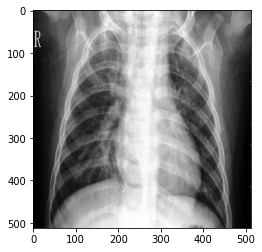

In [10]:
mask = X_train[541]
plt.imshow(np.squeeze(mask))

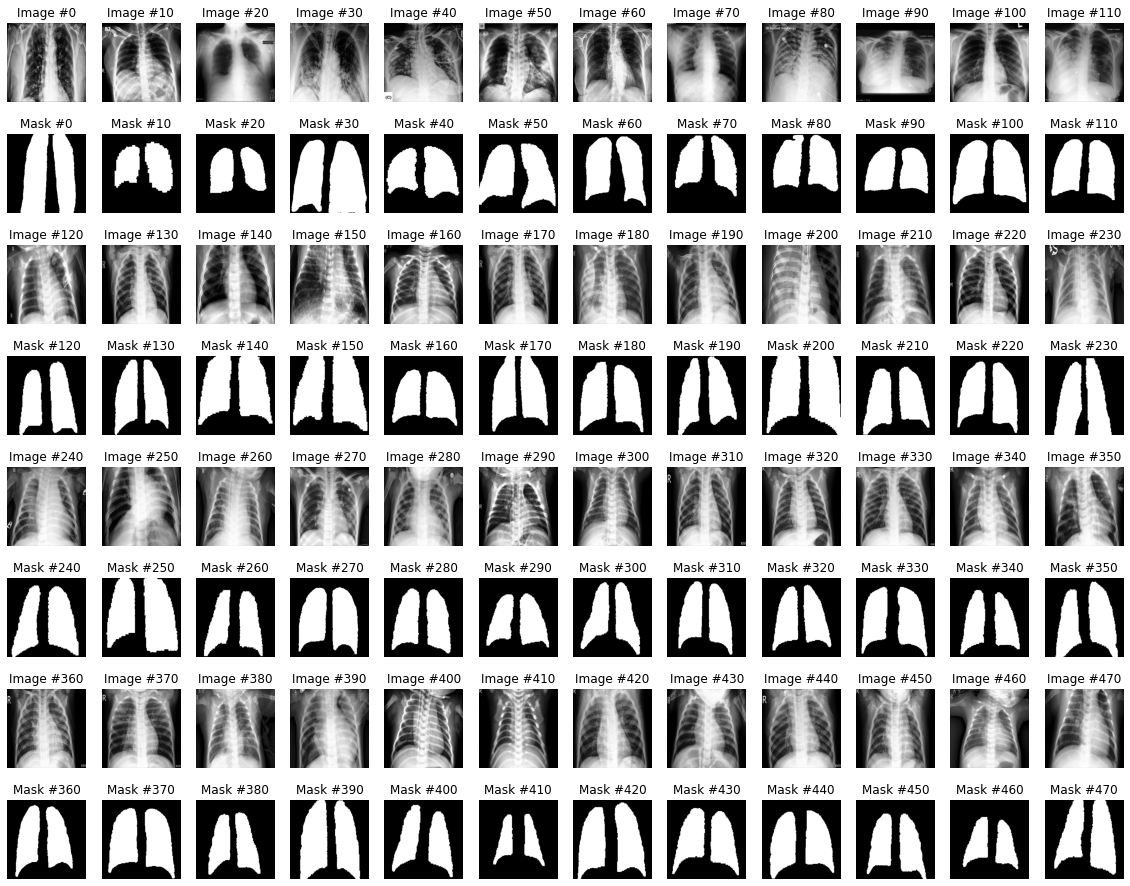

In [150]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [12]:
# Alternative IoU function
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/51553
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    print(y_true.shape)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

In [14]:
import tensorflow

In [15]:
iou = tensorflow.keras.metrics.MeanIoU(2, name=None, dtype=None)


In [48]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.7 + (i*.03)  for i in range(2)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [21]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [ ]:
def iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [50]:
from keras import backend as K
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [52]:
from src.metrics import jaccard, dice

In [23]:
import tensorflow as tf

In [24]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
_____________

In [25]:
# Initialize our callbacks
model_path = "./models/my_unet_my_iou.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)



# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.15,batch_size=8, epochs=100, callbacks=[earlystop,checkpoint])

Train on 590 samples, validate on 105 samples
Epoch 1/100
584/590 [============================>.] - ETA: 2s - loss: 0.4929 - my_iou_metric: 0.0016
Epoch 00001: val_loss improved from inf to 0.33144, saving model to ./models/my_unet_my_iou.h5
590/590 [==============================] - 314s 532ms/sample - loss: 0.4903 - my_iou_metric: 0.0018 - val_loss: 0.3314 - val_my_iou_metric: 0.0229
Epoch 2/100
584/590 [============================>.] - ETA: 3s - loss: 0.2205 - my_iou_metric: 0.0386
Epoch 00002: val_loss improved from 0.33144 to 0.20578, saving model to ./models/my_unet_my_iou.h5
590/590 [==============================] - 333s 565ms/sample - loss: 0.2200 - my_iou_metric: 0.0388 - val_loss: 0.2058 - val_my_iou_metric: 0.1378
Epoch 3/100
584/590 [============================>.] - ETA: 3s - loss: 0.1813 - my_iou_metric: 0.0588
Epoch 00003: val_loss improved from 0.20578 to 0.20503, saving model to ./models/my_unet_my_iou.h5
590/590 [==============================] - 334s 567ms/sample 

epochs: 100, overall time: 140m, mean epoch time: 121.74383s


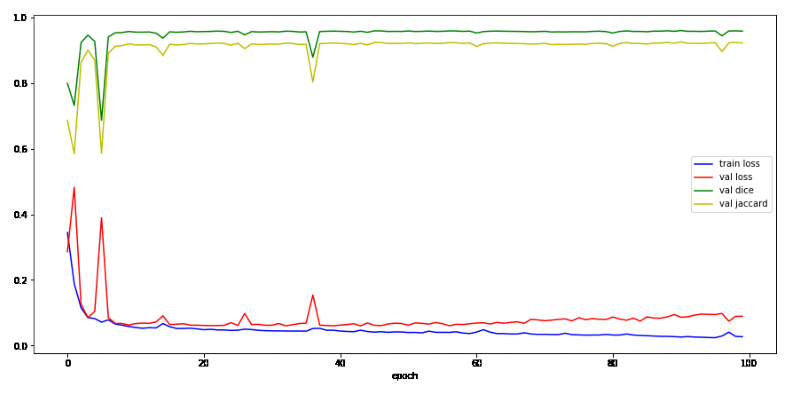

In [239]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [ ]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [27]:
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

67/67 [==============================] - 6s 82ms/sample


In [211]:
preds_test = model.predict(X_tst, verbose=1)


preds_tst_t1 = (preds_test > 0.5).astype(np.uint8)

4/4 [==============================] - 0s 19ms/sample


In [203]:
preds_test_t .shape

(28, 128, 128, 1)

In [36]:
preds_test1 = model.predict(X_tst, verbose=1)
preds_test_t1 = (preds_test1 > 0.5).astype(np.uint8)

5/5 [==============================] - 0s 20ms/sample


In [35]:
ix = random.randint(0, 67)


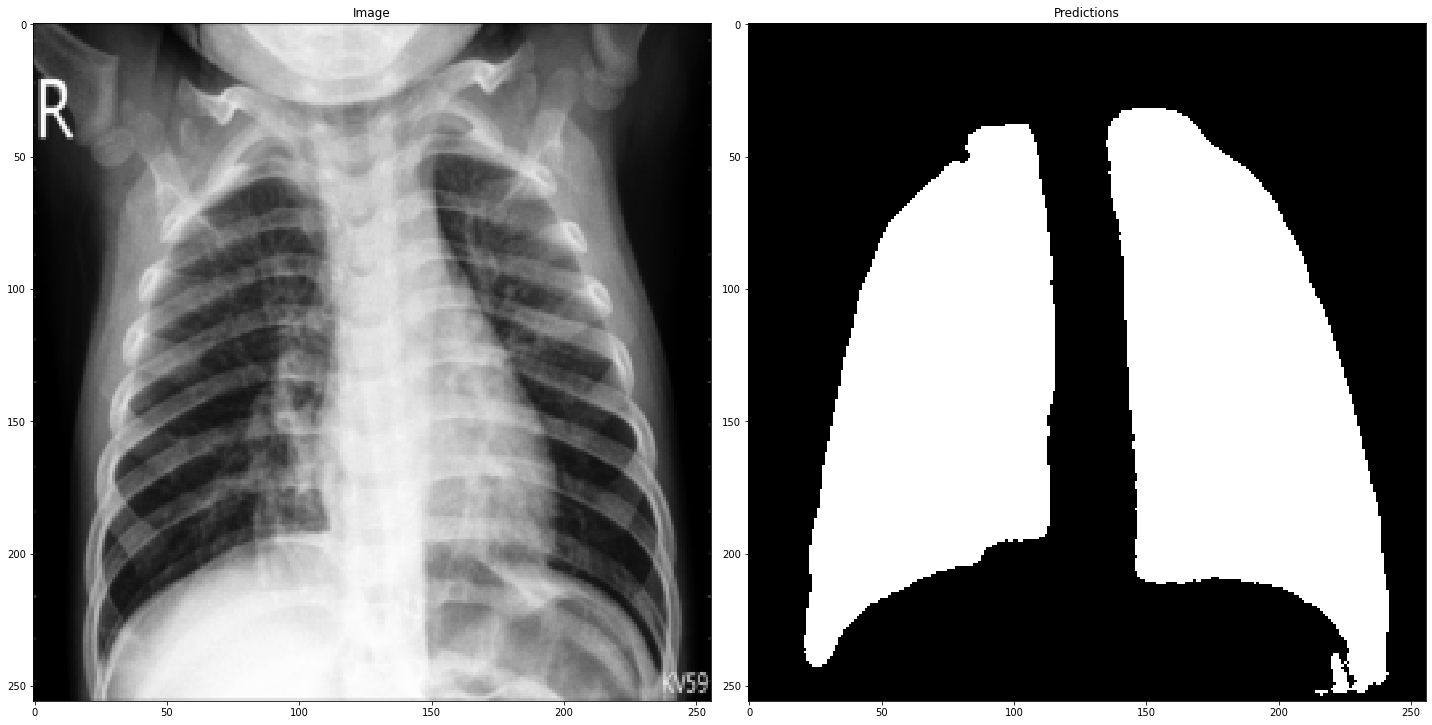

In [36]:
# Ploting our predicted masks
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_test[ix])
plt.title("Image")

# Our original combined mask  


# The mask our U-Net model predicts
plt.subplot(122)
imshow(np.squeeze(preds_test[ix] > 0.5))
plt.title("Predictions")
plt.show()

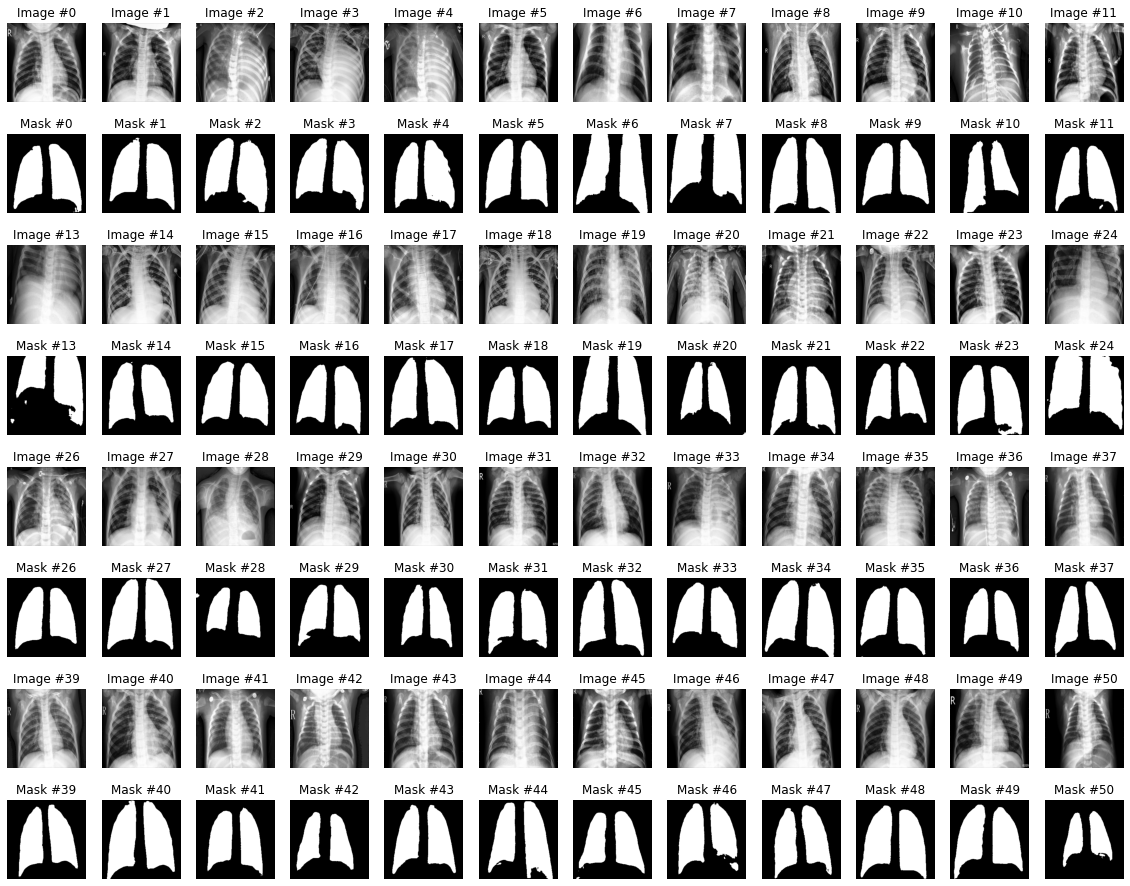

In [214]:
# Illustrate the predicted masks on test images
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos =  i+(j+ (12*i))
        plt.imshow(X_test[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(preds_test[pos] > 0.5),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

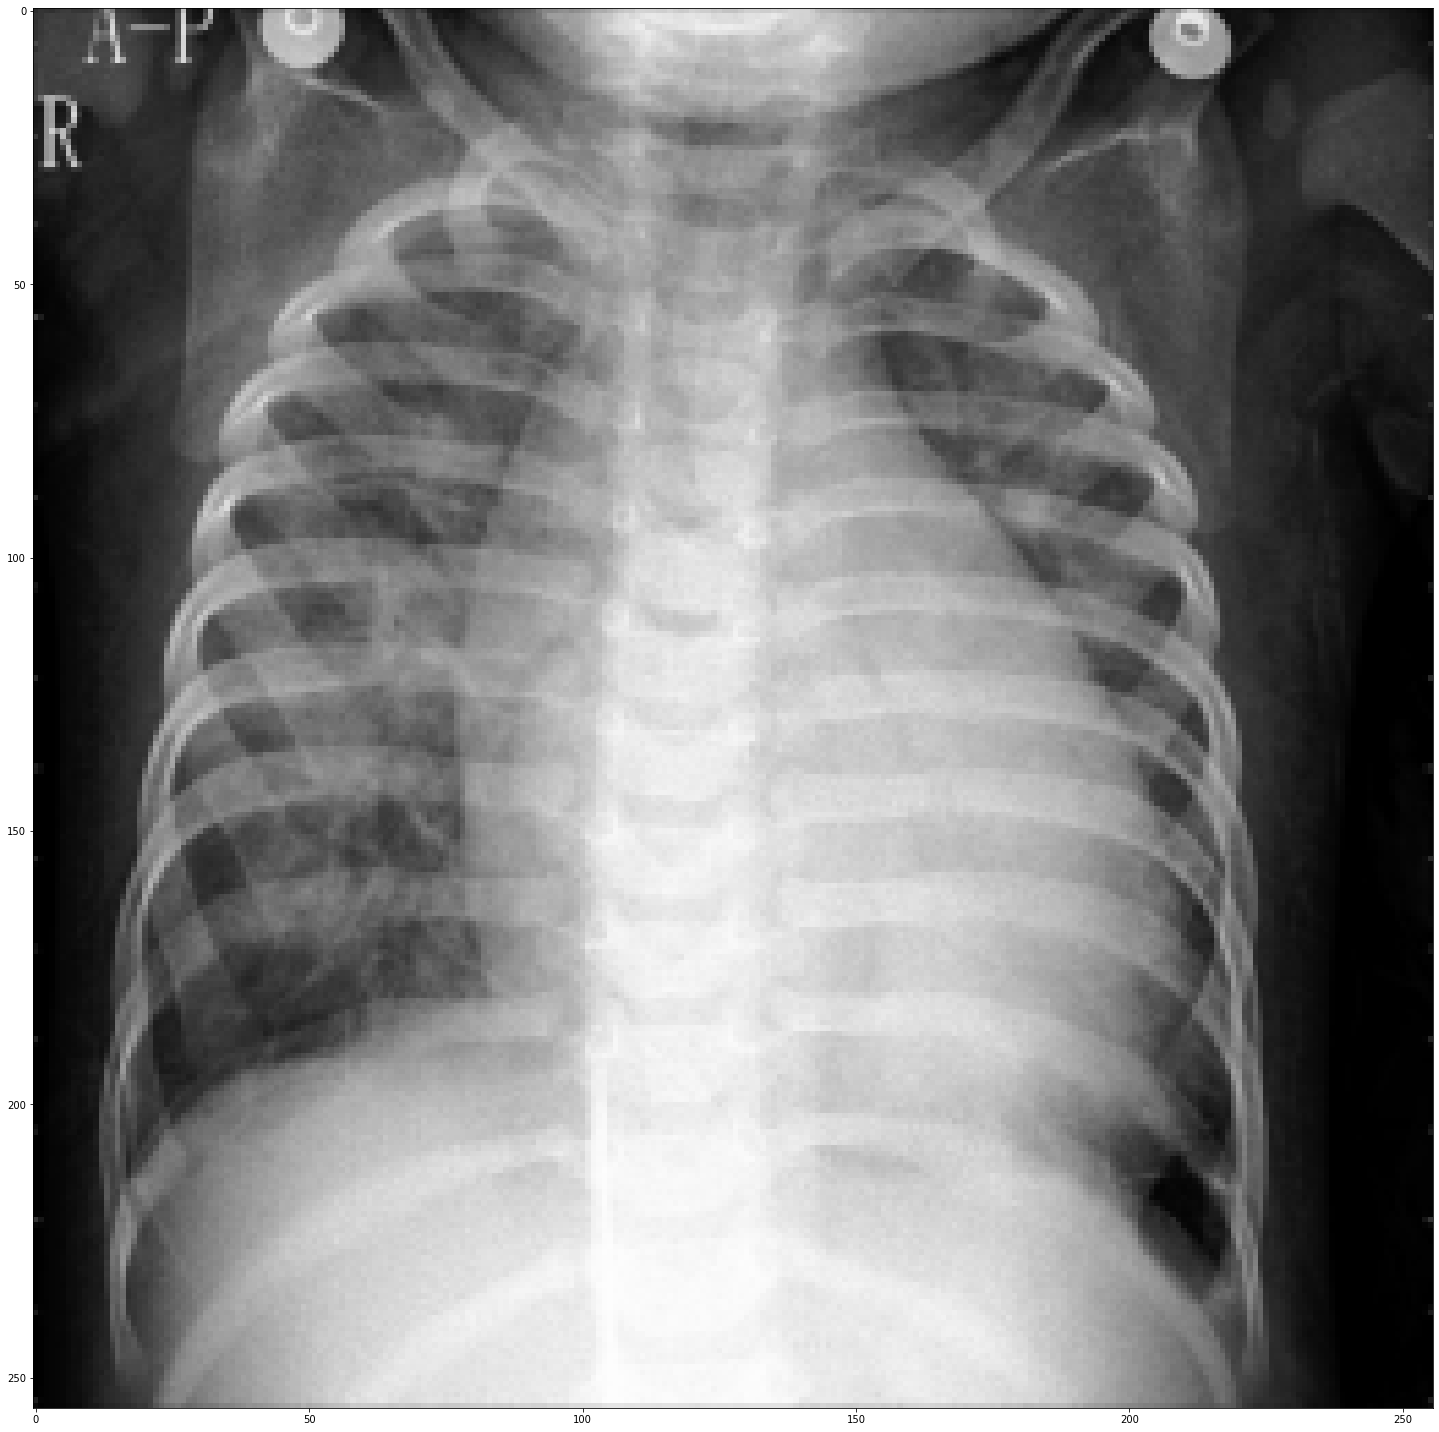

In [30]:
# ix = random.randint(0, 67)
plt.figure(figsize=(20,20))

imshow(X_test[ix])

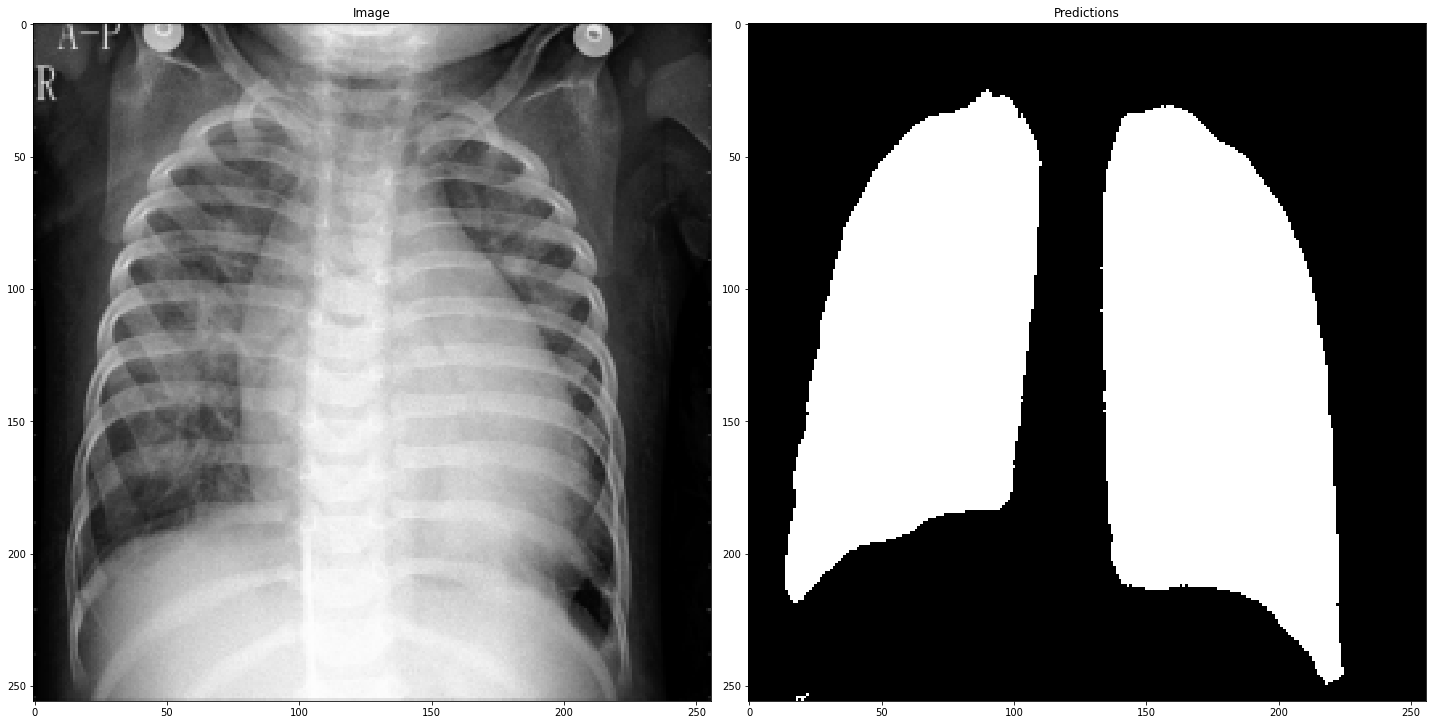

In [29]:
# Ploting our predicted masks
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_test[ix])
plt.title("Image")

# Our original combined mask  


# The mask our U-Net model predicts
plt.subplot(122)
imshow(np.squeeze(preds_test[ix] > 0.5))
plt.title("Predictions")
plt.show()

### WHY EXPERIMENT WITH IOU?

TypeError: Expected Ptr<cv::UMat> for argument 'src2'

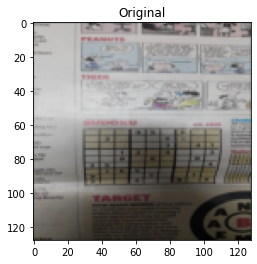

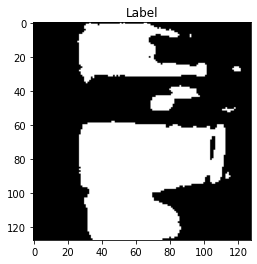

In [46]:
plt.figure()
plt.imshow(X_tst[ix])
plt.title("Original")
plt.figure()
plt.imshow(np.squeeze(preds_test_t1[ix] > 0.5),cmap='gray')
plt.title("Label")
dst = cv2.addWeighted(X_tst[ix],0.7,prd,0.3,0)
plt.figure()
plt.imshow(dst)
plt.title("Blending")

In [38]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)


625/625 [==============================] - 57s 91ms/sample


In [39]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)


In [40]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	2	0	0	1.000
0.550	2	0	0	1.000
0.600	2	0	0	1.000
0.650	2	0	0	1.000
0.700	2	0	0	1.000
0.750	2	0	0	1.000
0.800	2	0	0	1.000
0.850	2	0	0	1.000
0.900	1	1	1	0.333
0.950	0	2	2	0.000
AP	-	-	-	0.833


0.8333333333333334

In [41]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [42]:
import numpy
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
from scipy.ndimage.measurements import label, find_objects
from scipy.stats import pearsonr
def hd95(result, reference, voxelspacing=None, connectivity=1):
    """
    95th percentile of the Hausdorff Distance.

    Computes the 95th percentile of the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. Compared to the Hausdorff Distance, this metric is slightly more stable to small outliers and is
    commonly used in Biomedical Segmentation challenges.

    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.

    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.

    See also
    --------
    :func:`hd`

    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity)
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity)
    hd95 = numpy.percentile(numpy.hstack((hd1, hd2)), 95)
    return hd95

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds


In [43]:
TEST_PATH

'./test/'

In [44]:
filename_test = [f for f in listdir(TEST_PATH+'masks/') if isfile(join(TEST_PATH+'masks/',f))]

In [45]:
filename_test

['960458.jpg',
 '960460.jpg',
 '960462.jpg',
 '960463.jpg',
 '960464.jpg',
 '960465.jpg',
 '960467.jpg',
 '960468.jpg',
 '960469.jpg',
 '960471.jpg',
 '960472.jpg',
 '960473.jpg',
 '960474.jpg',
 '960475.jpg',
 '960476.jpg',
 '960477.jpg',
 '960478.jpg',
 '960479.jpg',
 '960480.jpg',
 '960481.jpg',
 '960482.jpg',
 '960483.jpg',
 '960484.jpg',
 '960486.jpg',
 '960487.jpg',
 '960488.jpg',
 '960489.jpg',
 '960490.jpg',
 '960492.jpg',
 '960493.jpg',
 '960764.jpg',
 '960765.jpg',
 '960766.jpg',
 '960767.jpg',
 '960768.jpg',
 '960770.jpg',
 '960771.jpg',
 '960772.jpg',
 '960773.jpg',
 '960774.jpg',
 '960775.jpg',
 '960776.jpg',
 '960777.jpg',
 '960778.jpg',
 '960779.jpg',
 '960780.jpg',
 '960781.jpg',
 '960782.jpg',
 '960783.jpg',
 '960784.jpg',
 '960785.jpg',
 '960786.jpg',
 '960787.jpg',
 '960788.jpg',
 '960789.jpg',
 '960790.jpg',
 '960791.jpg',
 '960792.jpg',
 '960793.jpg',
 '963986.jpg',
 '965949.jpg',
 '965950.jpg',
 '965951.jpg',
 '966238.jpg',
 '966239.jpg',
 '966240.jpg',
 '966241.j

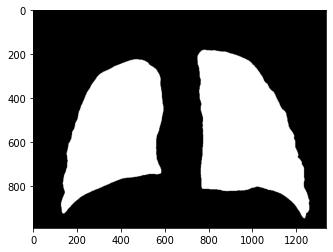

In [53]:
p=TEST_PATH+'masks/'+filename_test[0]
y = cv2.imread(p)
plt.imshow(y)

In [56]:
Y_test = np.zeros((len(filename_test), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(filename_test), total=len(filename_test)):
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(TEST_PATH + 'masks/' +filename_test[n])
    mask_ = rgb2gray(mask_)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
   
    Y_test[n] = mask


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  7.70it/s]


In [49]:
len(Y_test)

67

In [50]:
Y_test[0].shape

(992, 1336)

(256, 256)


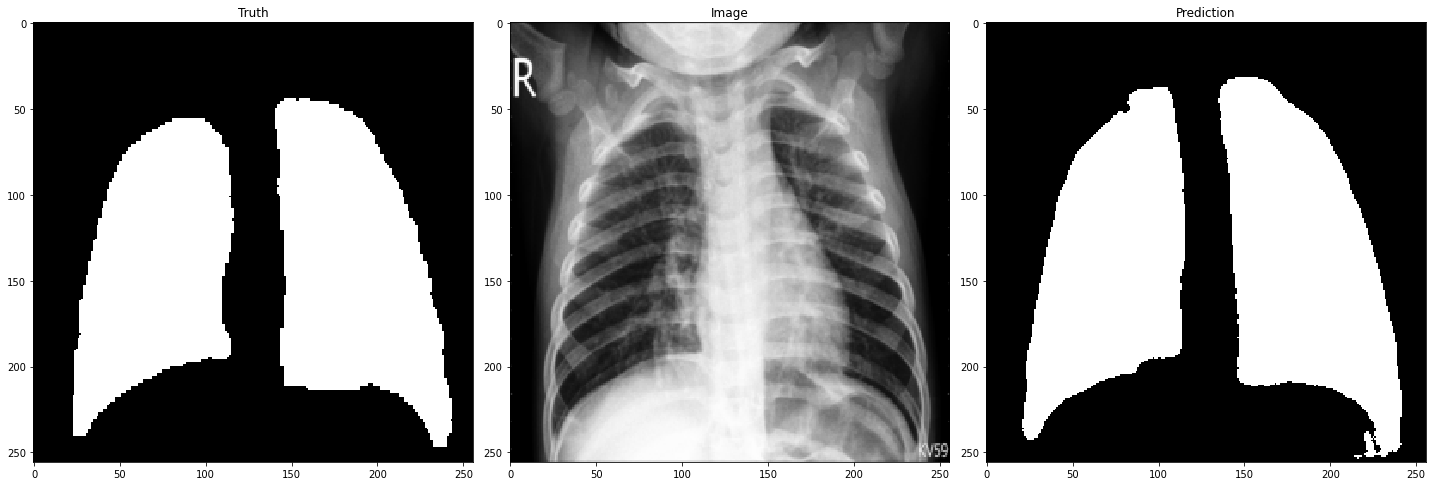

In [58]:
# Ploting our predicted masks
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(Y_test[ix])
plt.title("Truth")

plt.subplot(132)
imshow(X_test[ix])
plt.title("Image")

# Our original combined mask  


# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_test[ix] > 0.5))
print(np.squeeze(preds_test[ix] > 0.5).shape)
plt.title("Prediction")
plt.show()

(256, 256)
(256, 256)


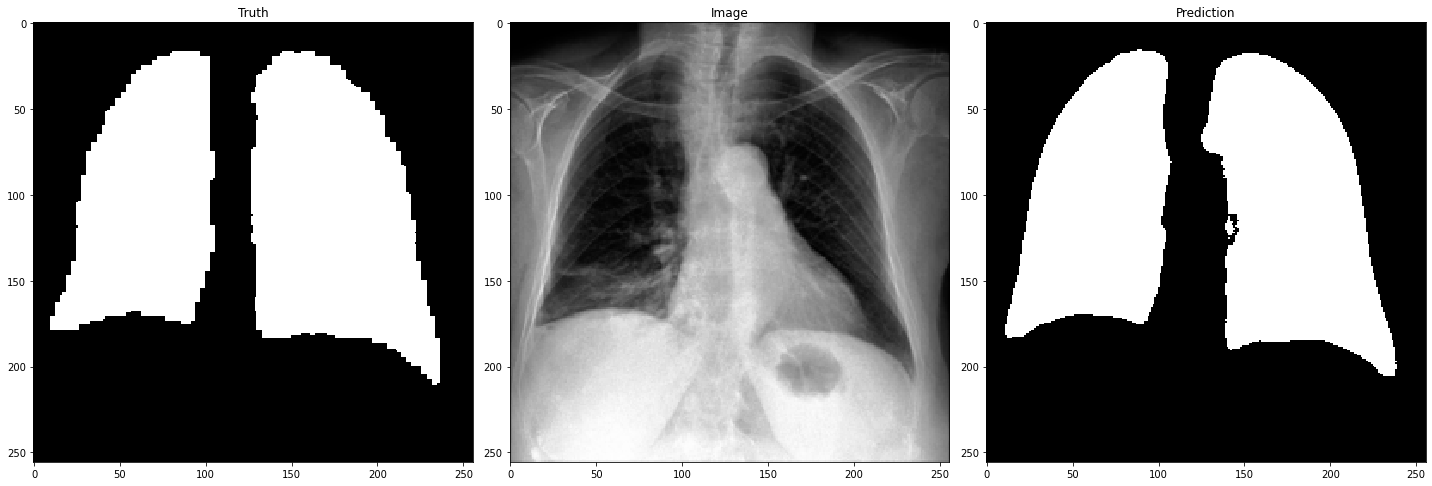

In [66]:
ix = 64
# Ploting our predicted masks
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(Y_test[ix])
print(np.squeeze(Y_test[ix]).shape)

plt.title("Truth")

plt.subplot(132)
imshow(X_test[ix])
plt.title("Image")

# Our original combined mask  


# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_test[ix] > 0.5))
print(np.squeeze(preds_test[ix] > 0.5).shape)
plt.title("Prediction")
plt.show()

In [67]:
dice(np.squeeze(Y_test[ix]),np.squeeze(preds_test[ix] > 0.5))

0.9498642533936652

In [68]:
hd95(np.squeeze(Y_test[ix]),np.squeeze(preds_test[ix] > 0.5))

11.17359094398334

In [152]:
from sklearn.metrics import jaccard_score,confusion_matrix


In [169]:

sens_list = []
spec_list=[]
acc_list = []

for i in range(len(filename_test)):
    
    cf = confusion_matrix(np.squeeze(Y_test[i]*1).ravel(),np.squeeze((preds_test[i]>0.5)*1).ravel())
    TP = cf[0][0]
    FP = cf[0][1]
    TN = cf[1][0]
    FN = cf[1][1]

    acc =(TP + TN) / (TP + TN + FP + FN)
    sens = TP / ( TP + FN )
    spec = TN / ( FP + TN )
    
    sens_list.append(sens)
    spec_list.append(spec)
    acc_list.append(acc)
    


In [171]:
sens_list = np.asarray(sens_list)
spec_list = np.asarray(spec_list)
acc_list = np.asarray(acc_list)

In [74]:
# Validate scans
dice_list = []
hd_list=[]
jaccard_list = []

for i in range(len(filename_test)):
    
    dice_list.append(dice(np.squeeze(Y_test[i]),np.squeeze(preds_test[i] > 0.5)))
    hd_list.append(hd95(np.squeeze(Y_test[i]),np.squeeze(preds_test[i] > 0.5)))
    jaccard_list.append(jaccard_score(np.squeeze(Y_test[i]).ravel(),np.squeeze(preds_test[i] > 0.5).ravel()))
    

    

In [77]:
dice_list = np.asarray(dice_list)
jaccard_list = np.asarray(jaccard_list)
hd_list = np.asarray(hd_list)

In [80]:
dice_list.mean()

0.9263893737305012

In [83]:
jaccard_list.mean()

0.8647036944120686

In [86]:
hd_list.mean()

15.679237409330668

# VALIDATION

In [194]:
print('DICE COEFFICIENT')
print(f' Max value - {dice_list.max() : 4f}')
print(f' Min value - {dice_list.min() : 4f}')
# print(f' Mean value - {dice_list.mean() : 4f}')
print(f' Med value - {np.median(dice_list) : 4f}')
# med = (dice_list.max()+dice_list.min())/2
print(f' Avg ± SD - {dice_list.mean() : 4f} ± {dice_list.std() : 4f}')



DICE COEFFICIENT
 Max value -  0.977634
 Min value -  0.836834
 Med value -  0.932780
 Avg ± SD -  0.926389 ±  0.034103


In [192]:
print('JACCARD SCORE')
print(f' Max value - {jaccard_list.max() : 4f}')
print(f' Min value - {jaccard_list.min() : 4f}')
print(f' Med value - {np.median(jaccard_list) : 4f}')
# print(f' Mean value - {jaccard_list.mean() : 4f}')
# med = (jaccard_list.max()+jaccard_list.min())/2
print(f' Avg ± SD - {jaccard_list.mean() : 4f} ± {jaccard_list.std() : 4f}')



JACCARD SCORE
 Max value -  0.956247
 Min value -  0.719445
 Med value -  0.874029
 Avg ± SD -  0.864704 ±  0.057677


In [237]:
dice_list[3]

0.8468104222821204

In [189]:
print('HAUSDORFF DISTANCE')
print(f' Max value - {hd_list.max() : 4f}')
print(f' Min value - {hd_list.min() : 4f}')
print(f' Med value - {np.median(hd_list) : 4f}')
# print(f' Mean value - {hd_list.mean() : 4f}')
# med = (hd_list.max()+hd_list.min())/2
print(f' Avg ± SD - {hd_list.mean() : 4f} ± {hd_list.std() : 4f}')



HAUSDORFF DISTANCE
 Max value -  36.441603
 Min value -  3.000000
 Med value -  16.000000
 Avg ± SD -  15.679237 ±  8.013009


In [195]:
print('SPECIFICITY')
print(f' Max value - {sens_list.max() : 4f}')
print(f' Min value - {sens_list.min() : 4f}')
print(f' Med value - {np.median(sens_list) : 4f}')
# print(f' Mean value - {sens_list.mean() : 4f}')
print(f' Avg ± SD - {sens_list.mean() : 4f} ± {sens_list.std() : 4f}')



SPECIFICITY
 Max value -  0.779247
 Min value -  0.452338
 Med value -  0.604656
 Avg ± SD -  0.602492 ±  0.066201


In [198]:
print('SENSITIVITY')
print(f' Max value - {spec_list.max() : 4f}')
print(f' Min value - {spec_list.min() : 4f}')
print(f' Med value - {np.median(acc_list) : 4f}')

# print(f' Mean value - {sens_list.mean() : 4f}')
print(f' Avg ± SD - {spec_list.mean() : 4f} ± {spec_list.std() : 4f}')



SENSITIVITY
 Max value -  0.974680
 Min value -  0.717192
 Med value -  0.811603
 Avg ± SD -  0.886047 ±  0.067014


In [185]:
print('ACCURACY')
print(f' Max value - {acc_list.max() : 4f}')
print(f' Min value - {acc_list.min() : 4f}')
print(f' Med value - {np.median(acc_list) : 4f}')
# print(f' Mean value - {sens_list.mean() : 4f}')
print(f' Avg ± SD - {acc_list.mean() : 4f} ± {acc_list.std() : 4f}')



ACCURACY
 Max value -  0.890436
 Min value -  0.564554
 Med value -  0.711603
 Avg ± SD -  0.710910 ±  0.064370


In [235]:
ix = int(np.where(hd_list == hd_list.max())[0])
ix

3

HIGHEST HAUSDORFF VALUE -  36.441603
(256, 256)
(256, 256)


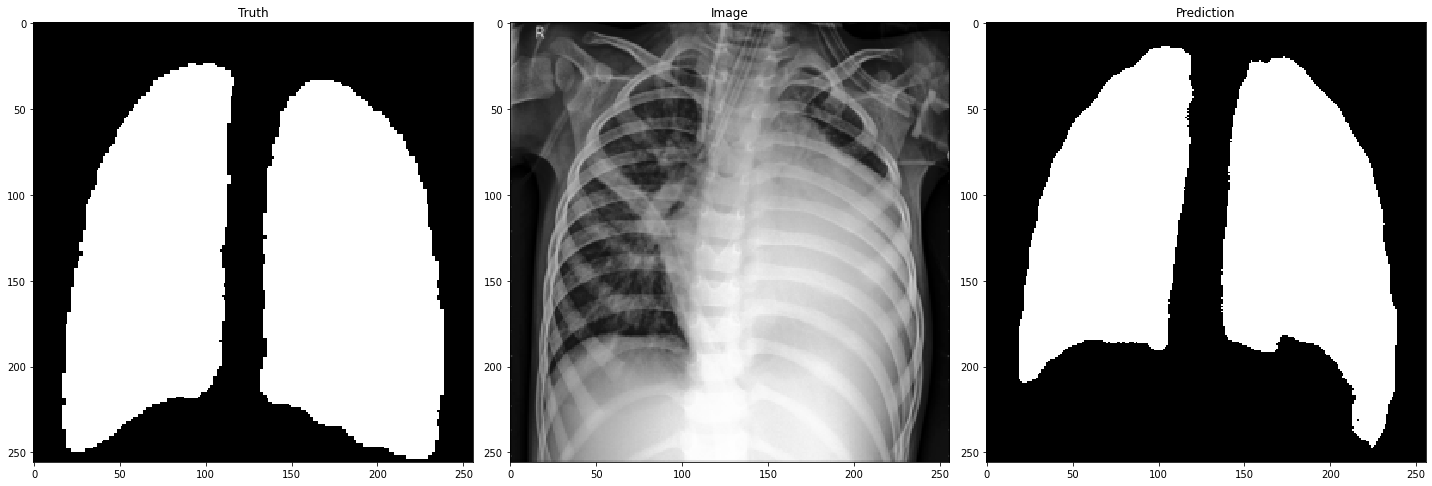

In [102]:
ix = int(np.where(hd_list == hd_list.max())[0])
# Ploting our predicted masks
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(Y_test[ix])
print(f'HIGHEST HAUSDORFF VALUE - {hd_list.max() : 4f}')
print(np.squeeze(Y_test[ix]).shape)

plt.title("Truth")

plt.subplot(132)
imshow(X_test[ix])
plt.title("Image")

# Our original combined mask  


# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_test[ix] > 0.5))
print(np.squeeze(preds_test[ix] > 0.5).shape)
plt.title("Prediction")
plt.show()

LEAST HAUSDORFF VALUE -  3.000000
(256, 256)
(256, 256)


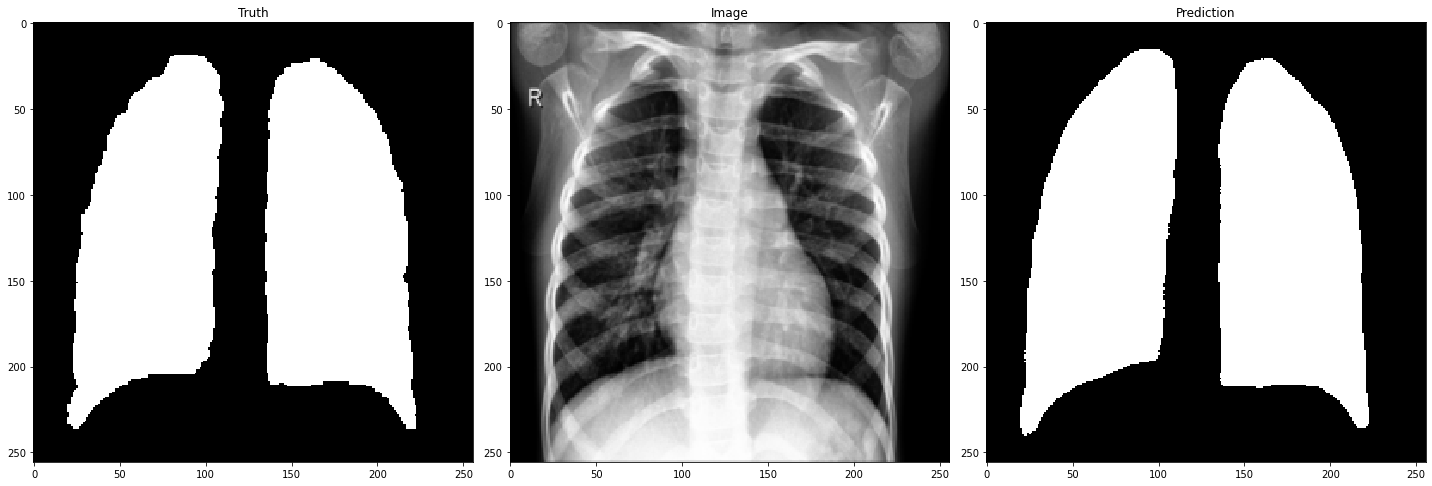

In [103]:
ix = int(np.where(hd_list == hd_list.min())[0])
# Ploting our predicted masks
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(Y_test[ix])
print(f'LEAST HAUSDORFF VALUE - {hd_list.min() : 4f}')

print(np.squeeze(Y_test[ix]).shape)

plt.title("Truth")

plt.subplot(132)
imshow(X_test[ix])
plt.title("Image")

# Our original combined mask  


# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_test[ix] > 0.5))
print(np.squeeze(preds_test[ix] > 0.5).shape)
plt.title("Prediction")
plt.show()

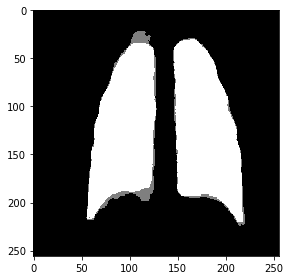

In [148]:
import operator
from PIL import Image
from PIL import ImageDraw

# suppose img1 and img2 are your two images
ix=30
img1 = Image.fromarray(np.squeeze(Y_test[ix]))
img2 = Image.fromarray(np.squeeze(preds_test[ix] > 0.5))

# suppose img2 is to be shifted by `shift` amount 
shift = (50, 60)

# compute the size of the panorama
nw, nh = 256,256

# paste img1 on top of img2
newimg1 = Image.new('RGBA', size=(nw, nh), color=(0, 0, 0, 0))
newimg1.paste(img2)
newimg1.paste(img1)

# paste img2 on top of img1
newimg2 = Image.new('RGBA', size=(nw, nh), color=(0, 0, 0, 0))
newimg2.paste(img1)
newimg2.paste(img2)

# blend with alpha=0.5
result = Image.blend(newimg1, newimg2, alpha=0.5)
imshow(np.array(result))

In [116]:
np.array(newimg1).shape

(256, 256, 4)

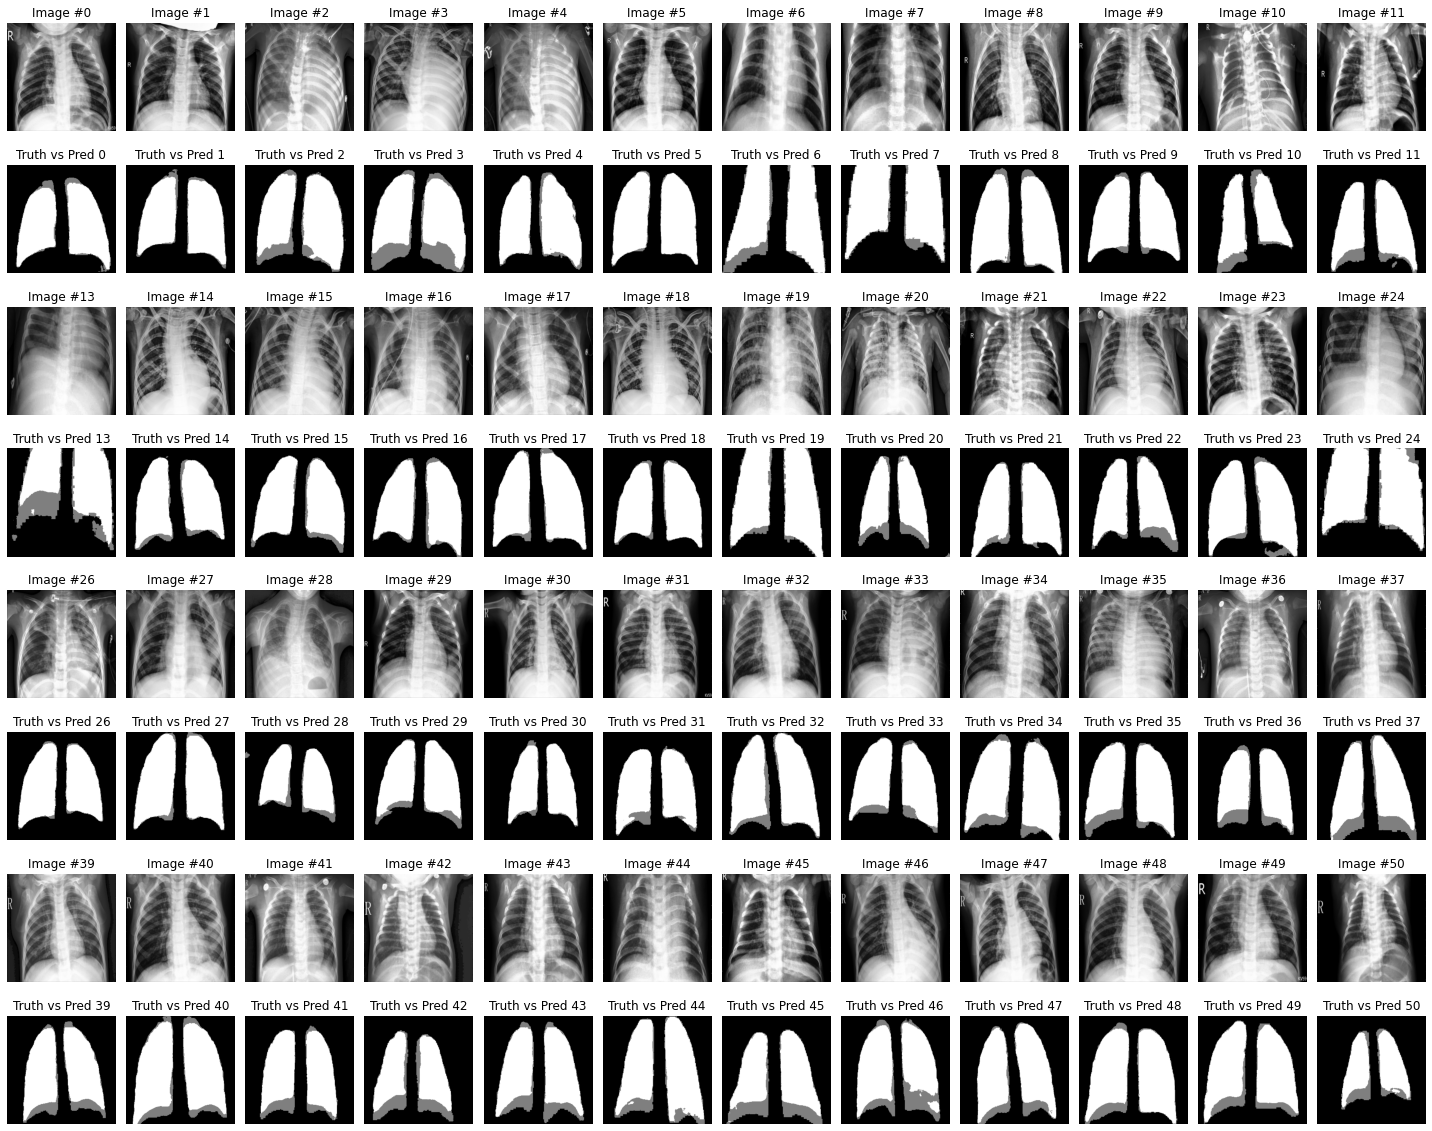

In [213]:
# Illustrate the predicted masks on test images
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+(j+ (12*i))
        plt.imshow(X_test[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        ix = pos
        img1 = Image.fromarray(np.squeeze(Y_test[ix]))
        img2 = Image.fromarray(np.squeeze(preds_test[ix] > 0.5))

        # suppose img2 is to be shifted by `shift` amount 
        shift = (50, 60)

        # compute the size of the panorama
        nw, nh = 256,256

        # paste img1 on top of img2
        newimg1 = Image.new('RGBA', size=(nw, nh), color=(0, 0, 0, 0))
        newimg1.paste(img2)
        newimg1.paste(img1)

        # paste img2 on top of img1
        newimg2 = Image.new('RGBA', size=(nw, nh), color=(0, 0, 0, 0))
        newimg2.paste(img1)
        newimg2.paste(img2)

        # blend with alpha=0.5
        result = Image.blend(newimg1, newimg2, alpha=0.5)
        plt.imshow(np.array(result),cmap='gray')
        plt.title('Truth vs Pred {}'.format(pos))
        plt.axis('off')

plt.tight_layout()
plt.show()

In [200]:
filename_test

['960458.jpg',
 '960460.jpg',
 '960462.jpg',
 '960463.jpg',
 '960464.jpg',
 '960465.jpg',
 '960467.jpg',
 '960468.jpg',
 '960469.jpg',
 '960471.jpg',
 '960472.jpg',
 '960473.jpg',
 '960474.jpg',
 '960475.jpg',
 '960476.jpg',
 '960477.jpg',
 '960478.jpg',
 '960479.jpg',
 '960480.jpg',
 '960481.jpg',
 '960482.jpg',
 '960483.jpg',
 '960484.jpg',
 '960486.jpg',
 '960487.jpg',
 '960488.jpg',
 '960489.jpg',
 '960490.jpg',
 '960492.jpg',
 '960493.jpg',
 '960764.jpg',
 '960765.jpg',
 '960766.jpg',
 '960767.jpg',
 '960768.jpg',
 '960770.jpg',
 '960771.jpg',
 '960772.jpg',
 '960773.jpg',
 '960774.jpg',
 '960775.jpg',
 '960776.jpg',
 '960777.jpg',
 '960778.jpg',
 '960779.jpg',
 '960780.jpg',
 '960781.jpg',
 '960782.jpg',
 '960783.jpg',
 '960784.jpg',
 '960785.jpg',
 '960786.jpg',
 '960787.jpg',
 '960788.jpg',
 '960789.jpg',
 '960790.jpg',
 '960791.jpg',
 '960792.jpg',
 '960793.jpg',
 '963986.jpg',
 '965949.jpg',
 '965950.jpg',
 '965951.jpg',
 '966238.jpg',
 '966239.jpg',
 '966240.jpg',
 '966241.j

In [211]:
for i in range(len(preds_test)):
    pred = np.asarray(np.squeeze(preds_test[i] > 0.5)*255,dtype='uint8')
    cv2.imwrite('./predictions/'+filename_test[i], pred)

In [210]:
(np.squeeze(preds_test[i] > 0.5)).max()

True

(-0.5, 697.5, 696.5, -0.5)

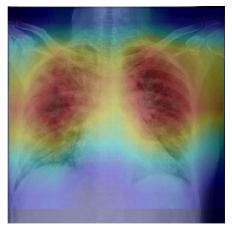

In [234]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'conv2d_72')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])


In [220]:
!pip install keras-vis